## Sammi Beard | Term Project

### Set Up

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [3]:
# import files

# https://www.kaggle.com/datasets/omarsobhy14/nba-players-salaries
NBA_sal_df = pd.read_csv('data/NBA-Player-Salaries-2022-2025.csv') 

# https://www.kaggle.com/datasets/loganlauton/nba-players-and-team-data?select=NBA+Player+Stats%281950+-+2022%29.csv
NBA_player_stats_df = pd.read_csv('data/NBA-Player-Stats(1950-2022).csv')

### Clean Data

#### NBA_sal_df

In [4]:
NBA_sal_df.head(3)

,Player Id,Player Name,2022/2023,2023/2024,2024/2025,2024/2025.1
0,1,Stephen Curry,"$48,070,014","$51,915,615","$55,761,217","$59,606,817"
1,2,John Wall,"$47,345,760",$0,$0,$0
2,3,Russell Westbrook,"$47,080,179",$0,$0,$0


In [5]:
# drop columns that have missing data and rename column
NBA_sal_df_clean = NBA_sal_df.drop(['Player Id', '2024/2025.1','2023/2024', '2024/2025'], axis=1)
NBA_sal_df_clean = NBA_sal_df_clean.rename(columns={'2022/2023': '2022_Salary'})
NBA_sal_df_clean.head(3)

,Player Name,2022_Salary
0,Stephen Curry,"$48,070,014"
1,John Wall,"$47,345,760"
2,Russell Westbrook,"$47,080,179"


#### NBA_player_stats_df

In [6]:
NBA_player_stats_df.head(3)

,Unnamed: 0.1,Unnamed: 0,Season,Player,Pos,Age,Tm,G,GS,MP,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,0,1950,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1,1950,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,2,1950,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0


In [7]:
# drop unnamed columns
NBA_player_stats_df_clean = NBA_player_stats_df.drop(['Unnamed: 0.1', "Unnamed: 0"], axis=1)

In [8]:
# rename columns for easier readability
NBA_player_stats_df_clean = NBA_player_stats_df_clean.rename(columns={'Pos': 'Position',
                                                                      'Tm': 'Team', 
                                                                      'Player': 'Player Name',
                                                                      'G': 'Games Played',
                                                                      'GS': 'Games Started',
                                                                      'MP': 'Minutes Played',
                                                                      'FGA': 'FG Attempted',
                                                                      'FG%': 'FG Percent',
                                                                      '3PA': '3P Attempted',
                                                                      '3P%': '3P Percent',
                                                                      '2PA': '2P Attempted',
                                                                      '2P%': '2P Percent',
                                                                      'eFG%': 'Effective FG',
                                                                      'FT': 'Free Throws',
                                                                      'FTA': 'Free Throws Attempted',
                                                                      'FT%': 'Free Throw Percent',
                                                                      'ORB': 'Offensive Rebound',
                                                                      'DRB': 'Defensive Rebound',
                                                                      'TRB': 'Total Rebound',
                                                                      'AST': 'Assist',
                                                                      'STL': 'Steals',
                                                                      'BLK': 'Block',
                                                                      'TOV': 'Turnovers',
                                                                      'PF': 'Personal Fouls',
                                                                      'PTS': 'Points'})

In [9]:
# convert season from string to date time
NBA_player_stats_df_clean['Season'] = pd.to_datetime(NBA_player_stats_df_clean['Season'], format='%Y')

In [10]:
# drop to the last few years of stats
NBA_player_stats_df_clean = NBA_player_stats_df_clean.loc[NBA_player_stats_df_clean['Season'].dt.year >= 2019]

In [11]:
# convert season from date time to year
NBA_player_stats_df_clean['Season'] = pd.DatetimeIndex(NBA_player_stats_df_clean['Season']).year

In [12]:
# exclude players who have 0 games played 
NBA_player_stats_df_clean = NBA_player_stats_df_clean[NBA_player_stats_df_clean['Games Played'] > 0]

In [13]:
NBA_player_stats_df_clean.head(3)

,Season,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FG Attempted,...,Free Throw Percent,Offensive Rebound,Defensive Rebound,Total Rebound,Assist,Steals,Block,Turnovers,Personal Fouls,Points
25361,2019,Álex Abrines,SG,25.0,OKC,31.0,2.0,588.0,56.0,157.0,...,0.923,5.0,43.0,48.0,20.0,17.0,6.0,14.0,53.0,165.0
25362,2019,Quincy Acy,PF,28.0,PHO,10.0,0.0,123.0,4.0,18.0,...,0.700,3.0,22.0,25.0,8.0,1.0,4.0,4.0,24.0,17.0
25363,2019,Jaylen Adams,PG,22.0,ATL,34.0,1.0,428.0,38.0,110.0,...,0.778,11.0,49.0,60.0,65.0,14.0,5.0,28.0,45.0,108.0


In [14]:
list(NBA_player_stats_df_clean.columns)

['Season',
 'Player Name',
 'Position',
 'Age',
 'Team',
 'Games Played',
 'Games Started',
 'Minutes Played',
 'FG',
 'FG Attempted',
 'FG Percent',
 '3P',
 '3P Attempted',
 '3P Percent',
 '2P',
 '2P Attempted',
 '2P Percent',
 'Effective FG',
 'Free Throws',
 'Free Throws Attempted',
 'Free Throw Percent',
 'Offensive Rebound',
 'Defensive Rebound',
 'Total Rebound',
 'Assist',
 'Steals',
 'Block',
 'Turnovers',
 'Personal Fouls',
 'Points']

In [15]:
# narrow seasons further to 2022 to match salary data we have
NBA_player_stats_df_2022 = NBA_player_stats_df_clean.loc[NBA_player_stats_df_clean['Season'] == 2022]

### Join Tables

In [16]:
stats_sal = NBA_sal_df_clean.set_index('Player Name').join(NBA_player_stats_df_2022.set_index('Player Name'))
stats_sal

,2022_Salary,Season,Position,Age,Team,Games Played,Games Started,Minutes Played,FG,FG Attempted,...,Free Throw Percent,Offensive Rebound,Defensive Rebound,Total Rebound,Assist,Steals,Block,Turnovers,Personal Fouls,Points
Player Name,,,,,,,,,,,,,,,,,,,,,
AJ Green,"$508,891",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AJ Griffin,"$3,536,160",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AJ Lawson,"$371,432",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Gordon,"$19,690,909",2022.0,PF,26.0,DEN,75.0,75.0,2376.0,434.0,834.0,...,0.743,125.0,314.0,439.0,188.0,44.0,44.0,133.0,148.0,1126.0
Aaron Holiday,"$1,968,175",2022.0,PG,25.0,TOT,63.0,15.0,1021.0,151.0,338.0,...,0.868,24.0,98.0,122.0,153.0,42.0,9.0,67.0,92.0,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach LaVine,"$37,096,500",2022.0,SG,26.0,CHI,67.0,67.0,2328.0,565.0,1186.0,...,0.853,22.0,286.0,308.0,303.0,41.0,23.0,171.0,120.0,1635.0
Zeke Nnaji,"$2,617,800",2022.0,PF,21.0,DEN,41.0,1.0,698.0,96.0,186.0,...,0.631,56.0,91.0,147.0,17.0,16.0,13.0,23.0,79.0,270.0
Zhaire Smith,"$1,068,200",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
stats_sal = stats_sal.reset_index(level=['Player Name'])

### Drop any features that are not useful for your model building and explain why they are not useful

Running correlation matrix to find variables with greater than 90% correlation and removing redundant data

In [18]:
stats_sal_corr = stats_sal.corr()

In [19]:
unstacked_corr = stats_sal_corr.unstack()
abs_unstacked_corr = unstacked_corr.abs()
sorted_corr = abs_unstacked_corr.sort_values()
sorted_corr

Steals          2P Percent       0.002791
2P Percent      Steals           0.002791
Total Rebound   3P Percent       0.005730
3P Percent      Total Rebound    0.005730
Turnovers       2P Percent       0.012473
                                   ...   
Steals          Season                NaN
Block           Season                NaN
Turnovers       Season                NaN
Personal Fouls  Season                NaN
Points          Season                NaN
Length: 729, dtype: float64

In [20]:
sorted_corr[609:651]

Free Throws            Points                   0.896784
Turnovers              FG                       0.902176
FG                     Turnovers                0.902176
Turnovers              Assist                   0.902364
Assist                 Turnovers                0.902364
Turnovers              FG Attempted             0.906786
FG Attempted           Turnovers                0.906786
Turnovers              Points                   0.909679
Points                 Turnovers                0.909679
Minutes Played         Points                   0.917233
Points                 Minutes Played           0.917233
                       2P                       0.921467
2P                     Points                   0.921467
FG                     Minutes Played           0.921587
Minutes Played         FG                       0.921587
FG Attempted           Minutes Played           0.922815
Minutes Played         FG Attempted             0.922815
FG Attempted           2P Attem

In [21]:
# drop redundant columns
stats_sal_essential = stats_sal.drop(['2P', '2P Attempted', '3P Attempted', 'Defensive Rebound', 'Effective FG', 
                                      'FG', 'FG Attempted', 'Free Throws Attempted', 'Minutes Played'], axis=1)

### Deal with missing data (do not just drop rows or columns without justifying this).

I will check if there are any players without salary.  If there are null values, I will fillna() with mean salary

In [22]:
stats_sal_essential[stats_sal_essential['2022_Salary'].isnull()]

,Player Name,2022_Salary,Season,Position,Age,Team,Games Played,Games Started,FG Percent,3P,...,Free Throws,Free Throw Percent,Offensive Rebound,Total Rebound,Assist,Steals,Block,Turnovers,Personal Fouls,Points


There are no null salaries for 2022.

I am dropping rows where I only had player salary and do not have any of their stats as we cannot determine if they are a good player or not.

In [23]:
stats_sal_essential[stats_sal_essential['Season'].isnull()]

,Player Name,2022_Salary,Season,Position,Age,Team,Games Played,Games Started,FG Percent,3P,...,Free Throws,Free Throw Percent,Offensive Rebound,Total Rebound,Assist,Steals,Block,Turnovers,Personal Fouls,Points
0,AJ Green,"$508,891",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AJ Griffin,"$3,536,160",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AJ Lawson,"$371,432",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,Alondes Williams,"$254,446",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Alperen Sengun,"$3,375,360",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,Willy Hernangomez,"$2,443,581",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
674,Xavier Cooks,"$140,384",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
679,Xavier Tillman,"$1,782,621",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
684,Zhaire Smith,"$1,068,200",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
stats_sal_essential.dropna(subset=['Season'], inplace=True)

In [25]:
stats_sal_essential[stats_sal_essential['Season'].isnull()]

,Player Name,2022_Salary,Season,Position,Age,Team,Games Played,Games Started,FG Percent,3P,...,Free Throws,Free Throw Percent,Offensive Rebound,Total Rebound,Assist,Steals,Block,Turnovers,Personal Fouls,Points


### Create dummy variables if necessary.

Instead of focusing on the specific player, I want to focus on their stats.  If I created dummies on Player Name it would be 500+ columns added. I will create dummies for position and team.

In [26]:
stats_sal_no_names = stats_sal_essential.drop(['Player Name'], axis=1)

In [27]:
stats_sal_dummies = pd.get_dummies(stats_sal_no_names, prefix=['Position', 'Team'], columns=['Position', 'Team'])

In [28]:
stats_sal_dummies

,2022_Salary,Season,Age,Games Played,Games Started,FG Percent,3P,3P Percent,2P Percent,Free Throws,...,Team_ORL,Team_PHI,Team_PHO,Team_POR,Team_SAC,Team_SAS,Team_TOR,Team_TOT,Team_UTA,Team_WAS
3,"$19,690,909",2022.0,26.0,75.0,75.0,0.520,87.0,0.335,0.605,171.0,...,0,0,0,0,0,0,0,0,0,0
4,"$1,968,175",2022.0,25.0,63.0,15.0,0.447,39.0,0.379,0.477,59.0,...,0,0,0,0,0,0,0,1,0,0
5,"$1,968,175",2022.0,25.0,41.0,14.0,0.467,23.0,0.343,0.524,28.0,...,0,0,0,0,0,0,0,0,0,1
6,"$1,968,175",2022.0,25.0,22.0,1.0,0.411,16.0,0.444,0.398,31.0,...,0,0,1,0,0,0,0,0,0,0
7,"$3,804,360",2022.0,22.0,52.0,3.0,0.396,31.0,0.270,0.612,21.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,"$1,968,175",2022.0,27.0,38.0,4.0,0.406,27.0,0.342,0.492,24.0,...,0,0,0,0,0,0,1,0,0,0
681,"$7,350,000",2022.0,24.0,28.0,4.0,0.490,14.0,0.341,0.544,52.0,...,0,0,0,0,0,1,0,0,0,0
682,"$37,096,500",2022.0,26.0,67.0,67.0,0.476,185.0,0.389,0.534,320.0,...,0,0,0,0,0,0,0,0,0,0
683,"$2,617,800",2022.0,21.0,41.0,1.0,0.516,37.0,0.463,0.557,41.0,...,0,0,0,0,0,0,0,0,0,0


### Futher cleaning

In [29]:
# salary is currently in a string, convert it to a number
stats_sal_dummies['2022_Salary'] = stats_sal_dummies['2022_Salary'].str.replace('$','', regex=True)
stats_sal_dummies['2022_Salary'] = stats_sal_dummies['2022_Salary'].str.replace(',','', regex=True)
stats_sal_dummies['2022_Salary'] = pd.to_numeric(stats_sal_dummies['2022_Salary'])

In [30]:
# find columns with na values
na_counts = stats_sal_dummies.isna().sum()
na_counts[na_counts>0] # na counts greater than zero

FG Percent             4
3P Percent            30
2P Percent            10
Free Throw Percent    31
dtype: int64

In [31]:
stats_sal_dummies['FG Percent'] = stats_sal_dummies['FG Percent'].fillna(stats_sal_dummies['FG Percent'].median())
stats_sal_dummies['3P Percent'] = stats_sal_dummies['3P Percent'].fillna(stats_sal_dummies['3P Percent'].median())
stats_sal_dummies['2P Percent'] = stats_sal_dummies['2P Percent'].fillna(stats_sal_dummies['2P Percent'].median())
stats_sal_dummies['Free Throw Percent'] = stats_sal_dummies['Free Throw Percent'].fillna(
    stats_sal_dummies['Free Throw Percent'].median())

### EDA

[Text(0.5, 0, 'Points'),
 Text(0, 0.5, 'Salary'),
 Text(0.5, 1.0, 'Salary (10M) Vs Points')]

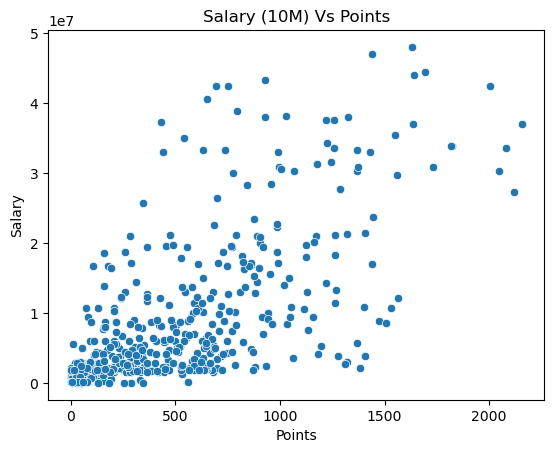

In [32]:
sal_points = sns.scatterplot(x='Points', y='2022_Salary', data=stats_sal_dummies)
sal_points.set(xlabel ="Points", ylabel = "Salary", title ='Salary (10M) Vs Points')

[Text(0.5, 0, 'Field Goal Percent'),
 Text(0, 0.5, 'Salary'),
 Text(0.5, 1.0, 'Salary (10M) Vs Field Goal Percent')]

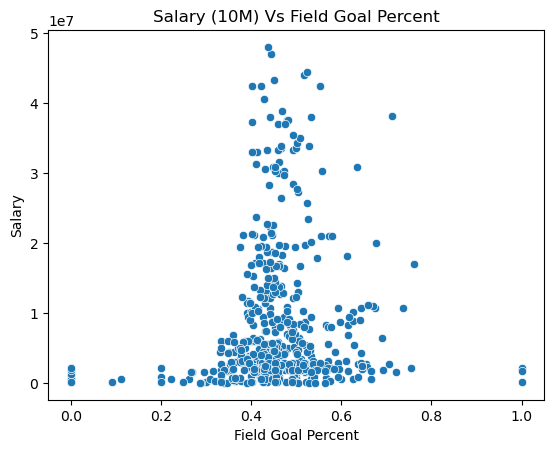

In [33]:
sal_FG = sns.scatterplot(x='FG Percent', y='2022_Salary', data=stats_sal_dummies)
sal_FG.set(xlabel ="Field Goal Percent", ylabel = "Salary", title ='Salary (10M) Vs Field Goal Percent')

[Text(0.5, 1.0, 'Games Played Vs Points')]

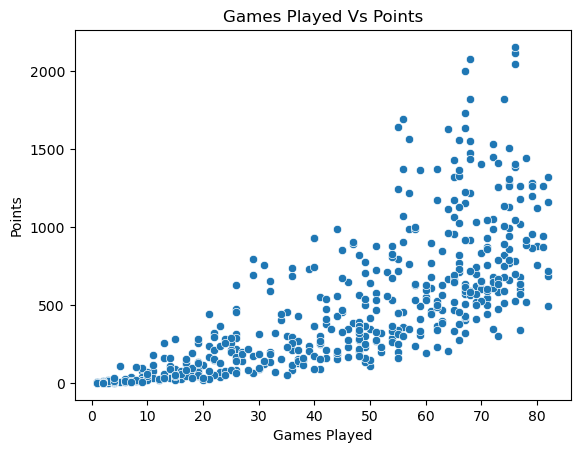

In [34]:
sns.scatterplot(x='Games Played', y='Points', data=stats_sal_dummies).set(title='Games Played Vs Points')

[Text(0.5, 1.0, 'Games Played Vs 2022 Salary')]

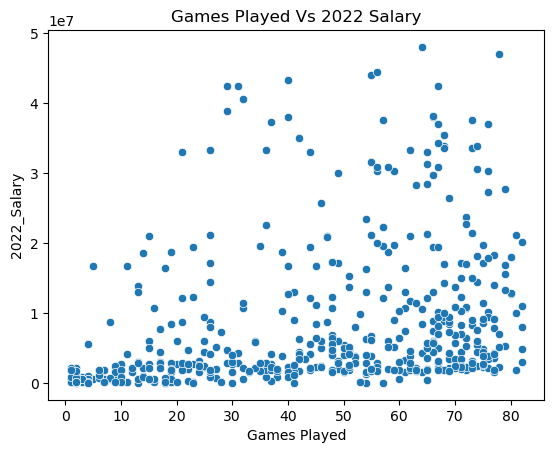

In [35]:
sns.scatterplot(x='Games Played', y='2022_Salary', data=stats_sal_dummies).set(title='Games Played Vs 2022 Salary')

[Text(0.5, 1.0, 'Points by Age')]

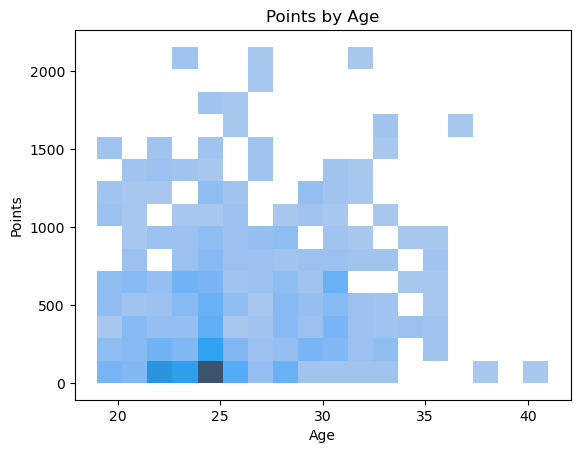

In [36]:
sns.histplot(x='Age', y='Points', data=stats_sal_dummies).set(title='Points by Age')

[Text(0.5, 1.0, 'Salary (10M) by Age')]

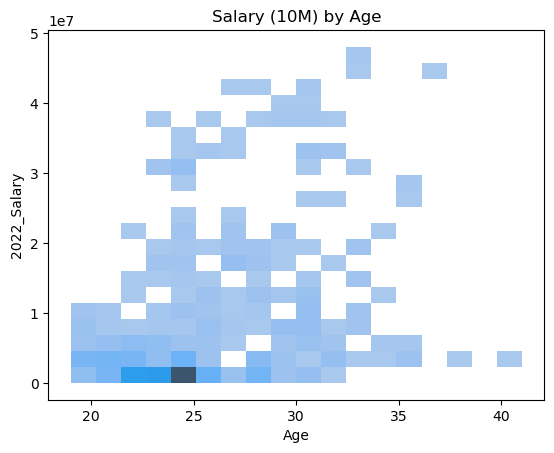

In [37]:
sns.histplot(x='Age', y='2022_Salary', data=stats_sal_dummies).set(title='Salary (10M) by Age')

[Text(0.5, 1.0, 'Rebounds V Points')]

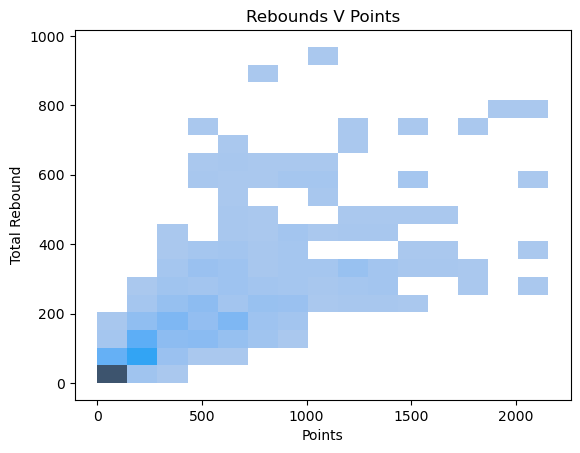

In [38]:
sns.histplot(x='Points', y='Total Rebound', data=stats_sal_dummies).set(title='Rebounds V Points')

[Text(0.5, 1.0, 'Rebounds V Salary')]

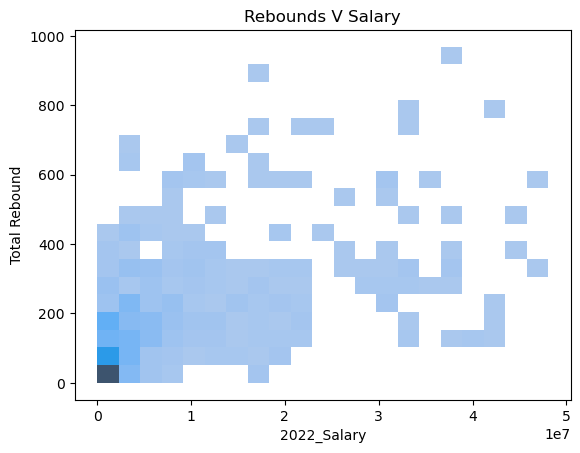

In [39]:
sns.histplot(x='2022_Salary', y='Total Rebound', data=stats_sal_dummies).set(title='Rebounds V Salary')

[Text(0.5, 1.0, 'Turnovers V Points')]

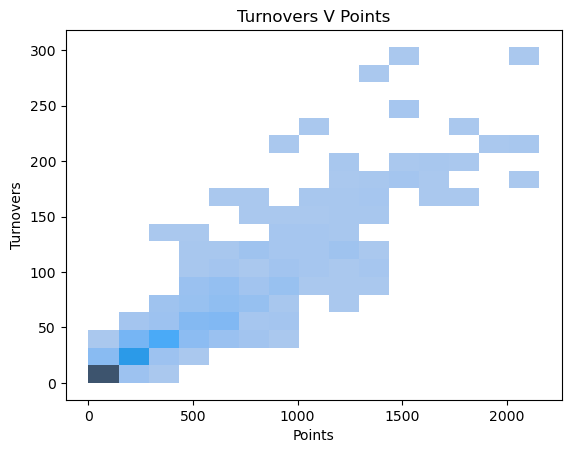

In [40]:
sns.histplot(x='Points', y='Turnovers', data=stats_sal_dummies).set(title='Turnovers V Points')

[Text(0.5, 1.0, 'Turnovers V Salary (10M)')]

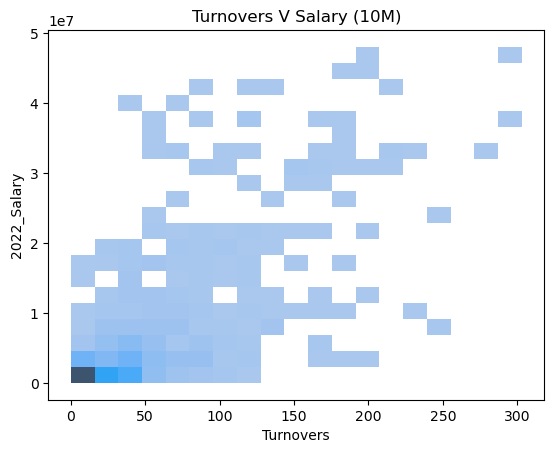

In [41]:
sns.histplot(x='Turnovers', y='2022_Salary', data=stats_sal_dummies).set(title='Turnovers V Salary (10M)')

[Text(0.5, 1.0, 'Personal Fouls V Points')]

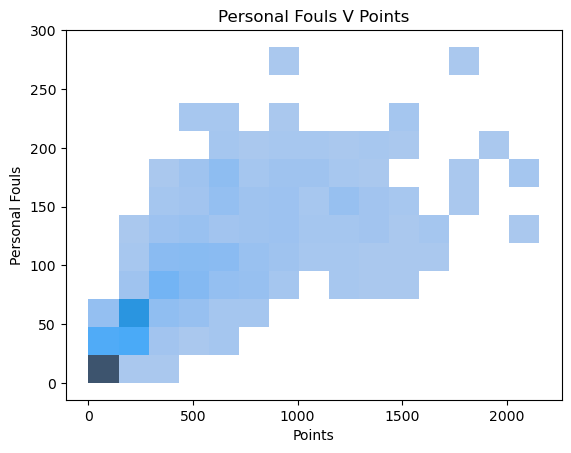

In [42]:
sns.histplot(x='Points', y='Personal Fouls', data=stats_sal_dummies).set(title='Personal Fouls V Points')

[Text(0.5, 1.0, 'Personal Fouls V Salary')]

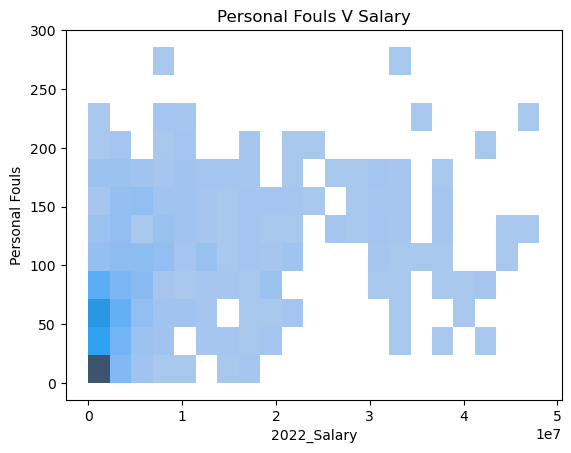

In [43]:
sns.histplot(x='2022_Salary', y='Personal Fouls', data=stats_sal_dummies).set(title='Personal Fouls V Salary')

### Split dataset

In [44]:
# determine targets
X = stats_sal_dummies.drop(['2022_Salary', 'Points'], axis=1)
y = stats_sal_dummies[['2022_Salary', 'Points']]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Create models

In [62]:
# Create and train the multi-target regression model (ElasticNet)
multioutput_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=75, 
                               criterion='poisson', 
                               random_state=1, 
                               n_jobs=1,
                               max_features=.6))
multioutput_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(criterion='poisson',
                                                     max_features=0.6,
                                                     n_estimators=75, n_jobs=1,
                                                     random_state=1))

In [63]:
# Create and train the decision tree regressor model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [64]:
# Create and train the random forest regressor model
forest_model = RandomForestRegressor(n_estimators=100, 
                               criterion='poisson', 
                               random_state=1, 
                               n_jobs=1,
                               max_features=.6)
forest_model.fit(X_train, y_train)

RandomForestRegressor(criterion='poisson', max_features=0.6, n_jobs=1,
                      random_state=1)

### Model Evaluation

In [65]:
# Make predictions
multioutput_pred = multioutput_model.predict(X_test)
tree_pred = tree_model.predict(X_test)
forest_pred = forest_model.predict(X_test)

In [66]:
# Calculate performance metrics for multioutput model
multioutput_mse = mean_squared_error(y_test, multioutput_pred)
multioutput_rmse = mean_squared_error(y_test, multioutput_pred, squared=False)
multioutput_mae = mean_absolute_error(y_test, multioutput_pred)
multioutput_r2 = r2_score(y_test, multioutput_pred, multioutput='raw_values')
print(f"The MSE is {multioutput_mse}.",
      f"\nThe RMSE is {multioutput_rmse}.",
      f"\nThe MAE is {multioutput_mae}.",
      f"\nThe R2 Score of salary is {multioutput_r2[0]} and of points {multioutput_r2[1]}.")

The MSE is 14911620308668.424. 
The RMSE is 2730585.8036343413. 
The MAE is 1806607.4916013316. 
The R2 Score of salary is 0.7164800203658392 and of points 0.9445674104300639.


In [67]:
# Calculate performance metrics for decision tree model
tree_mse = mean_squared_error(y_test, tree_pred)
tree_rmse = mean_squared_error(y_test, tree_pred, squared=False)
tree_mae = mean_absolute_error(y_test, tree_pred)
tree_r2 = r2_score(y_test, tree_pred, multioutput='raw_values')
print(f"The MSE is {tree_mse}.",
      f"\nThe RMSE is {tree_rmse}.",
      f"\nThe MAE is {tree_mae}.",
      f"\nThe R2 Score of salary is {tree_r2[0]} and of points {tree_r2[1]}.")

The MSE is 37062369008276.69. 
The RMSE is 4304893.093836926. 
The MAE is 2654536.208333333. 
The R2 Score of salary is 0.29531989908738543 and of points 0.7734564029245238.


In [68]:
# Calculate performance metrics for random forest model
forest_mse = mean_squared_error(y_test, forest_pred)
forest_rmse = mean_squared_error(y_test, forest_pred, squared=False)
forest_mae = mean_absolute_error(y_test, forest_pred)
forest_r2 = r2_score(y_test, forest_pred, multioutput='raw_values')
print(f"The MSE is {forest_mse}.",
      f"\nThe RMSE is {forest_rmse}.",
      f"\nThe MAE is {forest_mae}.",
      f"\nThe R2 Score of salary is {forest_r2[0]} and of points {forest_r2[1]}.")

The MSE is 15531240961282.39. 
The RMSE is 2786750.759724285. 
The MAE is 1846414.8065426752. 
The R2 Score of salary is 0.7046989509403154 and of points 0.9175455666304863.


### References

https://medium.com/@tubelwj/developing-multi-class-regression-models-with-python-c8beca5dd482#:~:text=Multi%2DTarget%20Regressor%3A%20This%20is,linear%20combination%20of%20input%20features.